# ANALISIS DE SENTIMIENTOS CONTEXTO PERU ##

### Librerias

In [1]:
#import warnings
#warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

#NLTK
import nltk
from nltk import word_tokenize, WordPunctTokenizer, regexp_tokenize
from nltk import word_tokenize, WordPunctTokenizer, regexp_tokenize

#Plotting 
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#Keras
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [2]:
#Funcion para cambiar valores de polaridad
def Cambiar_valor_polaridad(x):
    result = 0
    if x == 'POS':
        result = 1
    elif x == 'NEG':
        result = 0
    elif x == 'NEU':
        result =  -1
    return result

def Cambiar_formato(x):
    #print(x)
    result = ''
    if x == '0.0' or x == '0' :
        result = 'NEG'
    elif x == '1.0' or x == '1':
        result = 'POS'
    elif x == '-':
        result = 'NEU'
        
    return result

## DATASET PROPIO
* Leer dataset de cada contexto

In [135]:
#contexto pandemia 
df_pand = pd.read_csv("df_pandemiaF.csv")
#contexto politico
#df_pand = pd.read_csv("df_politicoF.csv")
#contexto pandemia con VM
#df_1 = pd.read_csv("df_pandemiafinalVM.csv")
#contexto politico con VM
#df_2 = pd.read_csv("df_politicofinalVM.csv")
#len(df)
#print(df.target.value_counts())

#df = df[(df['target'] == 'POS') | (df['target'] == 'NEG')]
#print(df.target.value_counts())
#df = df[['id','tweet','target_final']]
#df = df[(df['target'] == 'POS') | (df['target'] == 'NEG')]
#df = df[['id','tweet_sentence','target']]
#print(df.columns)

In [695]:
df_pand = pd.read_csv("df_pandemiaF.csv")
df_pand_rev = pd.read_csv("pand_VM_final.csv")
df_pand_rev = df_pand_rev[['id','tweet_sentence', 'target_final']]
df_pand_rev.columns = ['id','tweet_sentence', 'target']
#print(df_pand_rev.columns)
df_final = pd.concat([df_pand, df_pand_rev], ignore_index=False)
#df_final['target'].value_counts()
#print(df.target.value_counts())
#df_pol = pd.read_csv("df_politicoF.csv")
#print(df_rev.target.value_counts())
df_final.to_csv('df_pandemiafinalVM.csv')
print(df_final.columns)
print(df_final['target'].value_counts())

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'id', 'tweet',
       'tweet_sentence', 'len_sentence', 'username', 'date', 'nlikes',
       'tweet_word', 'len_word', 'POS', 'NEG', 'NEU', 'target'],
      dtype='object')
NEU    2025
NEG    1785
POS    1347
Name: target, dtype: int64


In [4]:
df_VM = pd.read_csv("pand_VM_final.csv")
print(len(df_VM))
df_pand_VM = df_VM[['id','tweet_sentence', 'target_final']]
df_pand_VM.columns = ['id','tweet_sentence', 'target']


815


In [5]:
df_VM = pd.read_csv("pol_VM_final.csv")
print(len(df_VM))
df_pol_VM = df_VM[['id','tweet_sentence', 'target_final']]
df_pol_VM.columns = ['id','tweet_sentence', 'target']


752


In [760]:
df_final = pd.read_csv("df_pandemiafinalVM.csv")
#df_final = pd.concat([df_pand, df_pol], ignore_index=False)
#df_final['target'].value_counts()
df_final.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'id', 'tweet', 'tweet_sentence', 'len_sentence', 'username', 'date',
       'nlikes', 'tweet_word', 'len_word', 'POS', 'NEG', 'NEU', 'target'],
      dtype='object')

In [136]:
df_final = pd.concat([df_1, df_2], ignore_index=False)

In [137]:
#df_final = pd.read_csv("df_pandemiaF.csv")
df_final = df_final[(df_final['target'] == 'POS') | (df_final['target'] == 'NEG')]
df_final['target'].value_counts()

NEG    4288
POS    3110
Name: target, dtype: int64

## Pre procesamiento de tweets

In [138]:
processed_tweets = df_final.copy()
processed_tweets['processed_tweet'] = df_final.tweet_sentence
#processed_tweets['processed_tweet'] = processed_tweets.tweetText
#processed_tweets.username.value_counts()
print(processed_tweets.target.value_counts())

### Procesamiento de caracteres especiales

#### 1. Hashtags: 
*Reemplazamos los hashtagas con la etiqueta __HASH__*

In [140]:
import re
hash_regex = re.compile(r"#(\w+)")
hstgs = [] # To store the hashtags so we can exclude them from some parts of the analysis
def hash_repl(match):
    _ = '__HASH_'+match.group(1).upper()
    hstgs.append(_)
    return _

#### 2. Usernames:
*Reemplazamos los usernames con la etiqueta __user__*

In [141]:
user_regex = re.compile(r"@(\w+)")
usr_names = [] # To store the user names so we can exclude them from some parts of the analysis
def user_repl(match):
    _ = '__user_'+match.group(1).upper()
    usr_names.append(_)
    return _

#### 3. URLs:
*Reemplazamos los URLs con la etiqueta __URL_*

In [142]:
url_regex = re.compile(r"(http|https|ftp)://[a-zA-Z0-9\./]+")
def url_repl(match):
    return '__URL_'

In [143]:
#processed_tweets['processed_tweet'] = [re.sub(url_regex, url_repl, str(s)) for s in processed_tweets.processed_tweet]
#processed_tweets

#### 4. Caracteres repetidos:
*Corregimos los caracteres repetidos 

In [144]:
# Repeating words like hurrrryyyyyy
rpt_regex = re.compile(r"(.)\1{1,}", re.IGNORECASE);
def rpt_repl(match):
    return match.group(1)+match.group(1)

In [145]:
# Test
re.sub(rpt_regex, rpt_repl, "Reppppeated characters in wordsssssssss" )

'Reppeated characters in wordss'

#### 5. Puntuación
* 

In [146]:
# Spliting by word boundaries
word_bound_regex = re.compile(r"\W+")

# Punctuations
punctuations = \
	[	#('',		['.', ] )	,\
		#('',		[',', ] )	,\
		#('',		['\'', '\"', ] )	,\
		('__PUNC_EXCL',		['!', '¡', ] )	,\
		('__PUNC_QUES',		['?', '¿', ] )	,\
		('__PUNC_ELLP',		['...', '…', ] )	,\
	]

#For punctuation replacement
def punctuations_repl(match):
	text = match.group(0)
	repl = []
	for (key, parr) in punctuations :
		for punc in parr :
			if punc in text:
				repl.append(key)
	if( len(repl)>0 ) :
		return ' '+' '.join(repl)+' '
	else :
		return ' '

In [147]:
#processed_tweets['processed_tweet'] = [re.sub(word_bound_regex, punctuations_repl, str(s)) for s in processed_tweets.processed_tweet]

### Stemming
* Utilizamos SnowballStemmer para obtener los radicales de las palabras

In [148]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('spanish')

In [1]:
# Test
text = processed_tweets.processed_tweet[21]
print(text)
text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) and (word not in usr_names))]
text = [stemmer.stem(w) for w in text]                
text = " ".join(text)
print('------------------')
print(text)

NameError: name 'processed_tweets' is not defined

In [150]:
def sb_stem(text, only_first=0):
    text = [word if(word[0:2]=='__') else word.lower() for word in text.split() if ((len(word) >= 3) or (word in ['no','si', 'sí', 'ni']))] #   If we are doing negation analysis, maybe is a better idea to keep the small words (like 'no')
    text = [stemmer.stem(w) if w[0:2]!='__' else w for w in text ]
    
    return(text)

** processAll incluye todos el pre-procesamiento de tweeets **

In [152]:
def processAll(text):
    text = re.sub( hash_regex, hash_repl, text )
    text = re.sub( user_regex, user_repl, text)
    text = re.sub( url_regex, url_repl, text )
    
    text = text.replace('\'','')
    
    text = re.sub( word_bound_regex , punctuations_repl, text )
    text = re.sub( rpt_regex, rpt_repl, text )
    
    text = sb_stem(text)    
    return text

## Feature Engineering

#### Creacion de diccionarios de emoticones:
* Consideramos 6 categorias para la clasificacion de emoticones

In [155]:
# Emoticons
emoticons = \
	[	# For __EMOT_SMILEY
        (' __emoji: U+1F601',	[':-)', ':)', '(:', '(-:', ] )	,\
        # for __EMOT_LAUGH
		(' __emoji: U+1F923',		[':-D', ':D', 'X-D', 'XD', 'xD', ] )	,\
        # For __EMOT_LOVE
		(' __emoji: U+2764',		['<3', ':\*', ] )	,\
        # For __EMOT_WINK
		('__emoji: U+1F609',		[';-)', ';)', ';-D', ';D', '(;', '(-;', ] )	,\
        # For __EMOT_FROWN
		(' __emoji: U+2639',		[':-(', ':(', '(:', '(-:', ] )	,\
        # For __EMOT_CRY
		(' __emoji: U+1F622',		[':,(', ':\'(', ':"(', ':(('] )	,\
	]
    
def escape_paren(arr):
	return [text.replace(')', '[)}\]]').replace('(', '[({\[]') for text in arr]

def regex_union(arr):
	return '(' + '|'.join( arr ) + ')'

emoticons_regex = [ (repl, re.compile(regex_union(escape_paren(regx))) ) for (repl, regx) in emoticons ]

*Los emojis se almacenan como combinaciones de caracteres, como :), por ese motivo los traduciremos a su valor unicode en esta etapa.*

In [156]:
# Test
text = "This is a text with one emoticon :) and another :("
for (repl, regx) in emoticons_regex :
    text = re.sub(regx, ' '+repl+' ', text)
    
print(text)

This is a text with one emoticon   __emoji: U+1F601  and another   __emoji: U+2639 


*Utilizamos un archivo archivo html que posee los unicode los emojis y seleccionamos los valores unicos*

In [157]:
# data scraped from http://www.unicode.org/emoji/charts/full-emoji-list.html
emojis_db=pd.read_csv('emojis_db_csv.csv')
emojis_db.head()

,emoji_category,number,code,CLDR_Short_Name
0,face-positive,1,U+1F600,grinning face
1,face-positive,2,U+1F601,beaming face with smiling eyes
2,face-positive,3,U+1F602,face with tears of joy
3,face-positive,4,U+1F923,rolling on the floor laughing
4,face-positive,5,U+1F603,grinning face with big eyes


In [158]:
emojis_db.emoji_category.unique()

array(['face-positive', 'face-neutral', 'face-negative', 'face-sick',
       'face-role', 'face-fantasy', 'cat-face', 'monkey-face', 'person',
       'person-role', 'person-fantasy', 'person-gesture',
       'person-activity', 'person-sport', 'family', 'body', 'hair-style',
       'emotion', 'clothing', 'animal-mammal', 'animal-bird',
       'animal-amphibian', 'animal-reptile', 'animal-marine',
       'animal-bug', 'plant-flower', 'plant-other', 'food-fruit',
       'food-vegetable', 'food-prepared', 'food-asian', 'food-sweet',
       'drink', 'dishware', 'place-map', 'place-geographic',
       'place-building', 'place-religious', 'place-other',
       'transport-ground', 'transport-water', 'transport-air', 'hotel',
       'time', 'sky & weather', 'event', 'award-medal', 'sport', 'game',
       'arts & crafts', 'sound', 'music', 'musical-instrument', 'phone',
       'computer', 'light & video', 'book-paper', 'money', 'mail',
       'writing', 'office', 'lock', 'tool', 'science', 'medi

*La siguiente función extraerá el unicode de cada emoji para que podamos usarlo como una función.*

In [159]:
def emojis_unicode(tweet):
    ''' Extracts the emojis on the tweet on Unicode format, also tries to match those in regular format, such as ";)" '''
    for (repl, regx) in emoticons_regex :
        tweet = re.sub(regx, ' '+repl+' ', tweet)
#     print(tweet)

    tweet_unicode = str(tweet.encode('unicode-escape'))
    tweet_unicode = tweet_unicode.replace('\\\\U000',' __emoji: U+')
#     print(tweet_unicode)
    
    emoji_list = []
#     print(tweet)
    for emoji in range(tweet_unicode.count(' __emoji: ')):
        em = tweet_unicode.split('__emoji: ')[emoji+1].split()[0]
        em = em[:7] # the len of the emoji in unicode is between 6 and 7
        emoji_list.append(em.upper())
    return emoji_list

In [160]:
# Test
text = "This is a text with one emoticon :) and another :( and some others: 😡 🤣😂"
emojis_unicode(text)

['U+1F601', 'U+2639', 'U+1F621', 'U+1F923', 'U+1F602']

In [161]:
#processed_tweets['emojis_unicode'] = processed_tweets.tweet.apply(emojis_unicode) # np.vectorize(emojis_unicode)(processed_tweets['tweetText'])

*Posteriormente el UNICODE es trandormado a cada categoria establecida*

In [162]:
def emoji_category(emojis):
    categories = []
    for i in range(len(emojis)):
        # print(emojis[i])
        try:
            categories.append(emojis_db.loc[emojis_db.code == emojis[i]].emoji_category.values[0])
        except:
            try:
                _ = emojis[i].split('+')[1] + '+'
                categories.append(emojis_db[emojis_db.code.str.contains(_)].emoji_category.values[0])
            except:
                categories.append('other')
    if len(categories) < 1:
        categories.append('no_emojis')
    return categories

emoji_category(emojis_unicode(text))

['face-positive',
 'face-negative',
 'face-negative',
 'face-positive',
 'face-positive']

In [163]:
#processed_tweets['emojis_categories'] = processed_tweets.emojis_unicode.apply(emoji_category)

In [164]:
#processed_tweets.head()

## Feature Engineering

### N-grams
*Utilizamos nltk.FreqDist() para inicializar las frecuencias de las palabras:*

In [2]:
# Unigrams
unigrams_fd = nltk.FreqDist()
# unigrams_fd.update(text)
# unigrams_fd

# Bigrams
# words_bi  = [ ','.join(map(str,bg)) for bg in nltk.bigrams(text) ]
bi_grams_fd = nltk.FreqDist()
# bi_grams_fd.update( words_bi )
# bi_grams_fd

# Trigrams
# words_tri  = [ ','.join(map(str,tg)) for tg in nltk.trigrams(text) ]
tri_grams_fd = nltk.FreqDist()
# tri_grams_fd.update( words_tri )
# tri_grams_fd

NameError: name 'nltk' is not defined

*Mediante get_word_features obtenemos las combinaciones de las palabras para n-grams(1,2,3)*

In [166]:
# Wrapper function that encloses all the n-grams procedures
def get_word_features(words):
    bag = {}
    words_uni = [ 'has(%s)'% ug for ug in words ]
    words_bi  = [ 'has(%s)'% ','.join(map(str,bg)) for bg in nltk.bigrams(words) ]
    words_tri = [ 'has(%s)'% ','.join(map(str,tg)) for tg in nltk.trigrams(words) ]
    
    for f in words_uni+words_bi+words_tri:
        bag[f] = 1

    return bag

### Negacion
*Utilizamos stemming nuevamente para obtener los radicles de cada palabras*

In [167]:
sb_stem('nunca no nada ningún ninguno ninguna tampoco')

['nunc', 'no', 'nad', 'ningun', 'ningun', 'ningun', 'tampoc']

In [168]:
negtn_regex = re.compile( r"""(?:
    ^(?:nunca|no|nada|ningún|ninguno|ninguna|tampoco|
        nunc|nad|ningun|tampoc
    )$
)
|
n't
""", re.X)

def get_negation_features(words):
    INF = 0.0
    negtn = [ bool(negtn_regex.search(w)) for w in words ]

    left = [0.0] * len(words)
    prev = 0.0
    for i in range(0,len(words)):
        if( negtn[i] ):
            prev = 1.0
        left[i] = prev
        prev = max( 0.0, prev-0.1)

    right = [0.0] * len(words)
    prev = 0.0
    for i in reversed(range(0,len(words))):
        if( negtn[i] ):
            prev = 1.0
        right[i] = prev
        prev = max( 0.0, prev-0.1)

    return dict( zip(
                    ['neg_l('+w+')' for w in  words] + ['neg_r('+w+')' for w in  words],
                    left + right ) )

In [ ]:
*Explicar ALE

In [169]:
# Test
text = ["Este","tweet", "no", "es", "positivo"]
get_negation_features(text)

{'neg_l(Este)': 0.0,
 'neg_l(tweet)': 0.0,
 'neg_l(no)': 1.0,
 'neg_l(es)': 0.9,
 'neg_l(positivo)': 0.8,
 'neg_r(Este)': 0.8,
 'neg_r(tweet)': 0.9,
 'neg_r(no)': 1.0,
 'neg_r(es)': 0.0,
 'neg_r(positivo)': 0.0}

### Apply Features
*extract_features engloba el pre procesmiento y el feature engineering para cada oracion*

In [174]:
# Wrapper function for the extraction of features
def extract_features(text):
    global usr_names, hstgs
    features = {}
    words = text
    words = processAll(text)

    word_features = get_word_features(words)
    features.update( word_features )

    negation_features = get_negation_features(words)
    features.update( negation_features )
        
    emoji_features = emoji_category(emojis_unicode(text))
    emoji_features_dic = dict( zip(['emoji_('+w+')' for w in  emoji_features], emoji_features))
    features.update( emoji_features_dic )
    
    usr_names = list(set(usr_names))
    hstgs = list(set(hstgs))
    return features

In [178]:
print(processed_tweets.target.value_counts())
processed_tweets['processed_tweet_features'] = processed_tweets.tweet_sentence.apply(extract_features)

NEG    4288
POS    3110
Name: target, dtype: int64


## Clasificación de tweets
*train_test_split se encargara de obtener el conjunto de datos para el train y test, con estas funcion podemos conseguir los conjuntos de datos estratificados*

In [179]:
X_train, X_test, y_train, y_test = train_test_split(processed_tweets[['id','tweet_sentence','processed_tweet','processed_tweet_features']], 
                                                    processed_tweets['target'], stratify = processed_tweets['target'], random_state = 20, test_size=0.20)

In [ ]:
train_ = X_train
train_['target'] = y_train
test_ = X_test
test_['target'] = y_test 

print(train_['target'].value_counts(), test_['target'].value_counts())

In [105]:
processed_tweets

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,id,tweet,tweet_sentence,len_sentence,username,date,nlikes,tweet_word,len_word,POS,NEG,NEU,target,processed_tweet,processed_tweet_features
0,10,10,10,1.233416e+18,Riesgo clave del COVID-19 es brote en países c...,Riesgo clave del COVID-19 es brote en países c...,5,AlfonsodlTorre,2020-02-28 10:36:23,2,"['Riesgo', 'clave', 'del', 'COVID-19', 'es', '...",13,0.000672,0.975066,0.024262,NEG,Riesgo clave del COVID-19 es brote en países c...,"{'has(riesg)': 1, 'has(clav)': 1, 'has(del)': ..."
1,11,11,11,1.233416e+18,Riesgo clave del COVID-19 es brote en países c...,China/Corea son países capaces de ejecutar pla...,5,AlfonsodlTorre,2020-02-28 10:36:23,2,"['China/Corea', 'son', 'países', 'capaces', 'd...",10,0.000672,0.975066,0.024262,NEG,China/Corea son países capaces de ejecutar pla...,"{'has(chin)': 1, 'has(core)': 1, 'has(son)': 1..."
2,12,12,12,1.233416e+18,Riesgo clave del COVID-19 es brote en países c...,"Un ejemplo es Irán, donde fatalidad del virus ...",5,AlfonsodlTorre,2020-02-28 10:36:23,2,"['Un', 'ejemplo', 'es', 'Irán', ',', 'donde', ...",13,0.000672,0.975066,0.024262,NEG,"Un ejemplo es Irán, donde fatalidad del virus ...","{'has(ejempl)': 1, 'has(iran)': 1, 'has(dond)'..."
3,13,13,13,1.233416e+18,Riesgo clave del COVID-19 es brote en países c...,O no se detectan casos o cobertura médica es p...,5,AlfonsodlTorre,2020-02-28 10:36:23,2,"['O', 'no', 'se', 'detectan', 'casos', 'o', 'c...",11,0.000672,0.975066,0.024262,NEG,O no se detectan casos o cobertura médica es p...,"{'has(no)': 1, 'has(detect)': 1, 'has(cas)': 1..."
4,14,14,14,1.233401e+18,Confirmado el primer caso de coronavirus covid...,Confirmado el primer caso de coronavirus covid...,3,PierolaMarcelo,2020-02-28 09:39:56,6,"['Confirmado', 'el', 'primer', 'caso', 'de', '...",22,0.001187,0.977370,0.021444,NEG,Confirmado el primer caso de coronavirus covid...,"{'has(confirm)': 1, 'has(prim)': 1, 'has(cas)'..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6369,10302,10302,10302,1.531074e+18,Agradecemos el saludo de la @ACTransparencia p...,Agradecemos el saludo de la @ACTransparencia p...,3,JNE_Peru,2022-05-29 19:42:45,20,"['Agradecemos', 'el', 'saludo', 'de', 'la', '@...",12,0.514830,0.011206,0.473965,POS,Agradecemos el saludo de la @ACTransparencia p...,"{'has(agradec)': 1, 'has(salud)': 1, 'has(__us..."
6370,10303,10303,10303,1.531074e+18,Agradecemos el saludo de la @ACTransparencia p...,Continuaremos trabajando incansablemente para ...,3,JNE_Peru,2022-05-29 19:42:45,20,"['Continuaremos', 'trabajando', 'incansablemen...",20,0.514830,0.011206,0.473965,POS,Continuaremos trabajando incansablemente para ...,"{'has(continu)': 1, 'has(trabaj)': 1, 'has(inc..."
6375,10318,10318,10318,1.542233e+18,"En entrevista a #JNETV, Mariani señaló que lo ...","En entrevista a #JNETV, Mariani señaló que lo ...",1,JNE_Peru,2022-06-29 14:47:08,5,"['En', 'entrevista', 'a', '#', 'JNETV', ',', '...",49,0.000673,0.988905,0.010422,NEG,"En entrevista a #JNETV, Mariani señaló que lo ...","{'has(entrev)': 1, 'has(__HASH_JNETV)': 1, 'ha..."
6376,10320,10320,10320,1.542167e+18,"Según el docente universitario, ""ejecutivo y l...","Según el docente universitario, ""ejecutivo y l...",1,JNE_Peru,2022-06-29 10:24:37,12,"['Según', 'el', 'docente', 'universitario', ',...",50,0.000674,0.980890,0.018436,NEG,"Según el docente universitario, ""ejecutivo y l...","{'has(segun)': 1, 'has(docent)': 1, 'has(unive..."


*Mediante este otro codigo obtenemos el train y test de forma aleatoria*

In [661]:
#sin estratificacion
import numpy as np

p_train = 0.70 # Porcentaje de train.
index_train = int(p_train*len(processed_tweets))
train_ = processed_tweets.iloc[:index_train]
#train_ = processed_tweets.values[:train_size]
test_ = processed_tweets.iloc[index_train:]
#train_, test_ = df[df['is_train']==True], df[df['is_train']==False]
#df = df.drop('is_train', 1)
#print(train_.columns)
y_train = train_['target']
y_test = test_['target'] 
print(train_['target'].value_counts())#, test_['target'].value_counts())
print(test_['target'].value_counts())#, test_['target'].value_counts())

NEG    2252
POS    1398
NEU    1393
Name: target, dtype: int64
NEU    1546
POS     365
NEG     251
Name: target, dtype: int64


In [181]:
train_size = int(train_.shape[0] - (train_.shape[0]+test_.shape[0])*0.1)
print(train_size)
sentiment_train_tweets = [(tweet, sentiment) for tweet, sentiment in train_[['tweet_sentence', 'target']].values[:train_size]]
sentiment_train_tweets_full = [(tweet, sentiment) for tweet, sentiment in train_[['tweet_sentence', 'target']].values[:train_size]]
sentiment_validation_tweets = [(tweet, sentiment) for tweet, sentiment in train_[['tweet_sentence', 'target']].values[train_size:]]
sentiment_test_tweets  = [(tweet, sentiment) for tweet, sentiment in test_[['tweet_sentence', 'target']].values]
#sentiment_train_tweets

5178


## Preparación de datos
*Cuando se trabaja con grandes corpus, la construcción de una sola lista que contiene las características de cada instancia puede consumir una gran cantidad de memoria. En estos casos, utilice la función nltk.classify.apply_features, que devuelve un objeto que actúa como una lista pero no almacena todos los conjuntos de funciones en la memoria:*

In [182]:
# Apply the data processing and cleaning extraction methodologies
v_train = nltk.classify.apply_features(extract_features,sentiment_train_tweets)
v_train_full = nltk.classify.apply_features(extract_features,sentiment_train_tweets_full)
v_validation = nltk.classify.apply_features(extract_features,sentiment_validation_tweets)
v_test  = nltk.classify.apply_features(extract_features,sentiment_test_tweets)
print(len(v_train), len(v_train_full), len(v_validation), len(v_test))

5178 5178 740 1480


## Cross Validation

In [202]:
def generar_entradas(tupla):
    lista_entradas = []
    lista_target = []
    for i in tupla:
        lista_entradas.append(list(i[0]))
        lista_target.append(i[1])
    return lista_entradas, lista_target

sentiment_tweets  = [(tweet, sentiment) for tweet, sentiment in processed_tweets[['tweet_sentence', 'target']].values]
df_final = nltk.classify.apply_features(extract_features,sentiment_tweets)
X, y = generar_entradas(df_final)

In [203]:
from statistics import mean
def cross_validation(num_folds, df_final, name_archivo, model):
    num_folds = num_folds
    subset_size = int(len(df_final)/num_folds)
    lista_acuracia = []
    lista_precision = []                  
    lista_recall = []                  

    for i in range(num_folds):
        #print(i, subset_size)
        testing_this_round = df_final[i*subset_size:][:subset_size]
        training_this_round = df_final[:i*subset_size] + df_final[(i+1)*subset_size:]
        # train using training
        nb_classifier = model
        nb_class = nb_classifier.train(training_this_round)
        # evaluate against testing_this_round
        y_test = []
        for i in testing_this_round:
            y_test.append(i[1])

        test_predict = [nb_class.classify(t) for (t,s) in testing_this_round]
        # save accuracy
        acuracia = accuracy_score(y_test, test_predict)
        precision = precision_score(y_test, test_predict, average="binary",pos_label='POS')
        recall = recall_score(y_test, test_predict, average="binary", pos_label='POS')
        #print(acuracia, precision, recall)
        lista_acuracia.append(acuracia)
        lista_precision.append(precision)
        lista_recall.append(recall)
    print(mean(lista_acuracia), mean(lista_precision), mean(lista_recall))
    
    #plotar_grafico(lista_acuracia, lista_precision, lista_recall, name_archivo, num_folds)
        #print('accuracia', acuracia)
        #print('precision', precision)
        #print('recall', recall)

In [205]:
#nltk.classify.SklearnClassifier(LinearSVC())
#nltk.classify.NaiveBayesClassifier
#nltk.classify.SklearnClassifier(RandomForestClassifier())
cross_validation(20,df_final,'cross_NB_20_F', nltk.classify.NaiveBayesClassifier)

0.8653116531165311 0.7840668414987841 0.8755220491336748


In [206]:
cross_validation(20,df_final,'cross_NB_20_F', nltk.classify.SklearnClassifier(LinearSVC()))

0.8520325203252033 0.8097342345757786 0.778318825946067


In [207]:
cross_validation(20,df_final,'cross_NB_20_F', nltk.classify.SklearnClassifier(RandomForestClassifier()))

0.8223577235772358 0.8279894554008868 0.6701958832880579


In [208]:
cross_validation(20,df_final,'cross_NB_20_F', perceptron_classifier)

0.8597560975609756 0.8150083267829225 0.8089492538209967


In [778]:
import matplotlib.pyplot as plt 
def plotar_grafico(list_acur, list_prec, list_recall, name_archivo, num_fold):
    x = np.arange(0, num_fold, 1)
    plt.figure(figsize=(20,6))
    #Generamos una grafica lineal para una recta en X
    plt.bar(x, list_acur, label='Acuracia', marker = "o", color='red', s =110)
    #Generamos otra grafica lineal para una X cuadratica
    plt.bar(x, list_prec, label='Precision' , marker='s', color='blue', s =110)
    #Generamos una grafica lineas para una X Cubica
    plt.bar(x, list_recall, label='Recall',  marker='p', color='green', s=110)
    #Agregamos las etiquetas y añadimos una leyenda.
    plt.xlabel('Fold')
    #grid()
    #plt.ylabel('')
    #plt.title("Simple Plot")
    plt.legend(fontsize=18)
    plt.savefig(name_archivo+'.pdf', dpi=500)
    plt.show()

In [338]:
import pandas as pd 
import matplotlib.pyplot as plt
data = pd.DataFrame({'Acuracia_2080' : [0.866, 0.850, 0.805, 0.867],
                     'Acuracia_VM_2080': [0.878, 0.852, 0.826, 0.882],
                     'Acuracia_fold' : [0.860, 0.840, 0.796, 0.851],
                     'Acuracia_VM_fold': [0.865, 0.852, 0.822, 0.860],},
                    index=('NB', 'SVM', 'RF', 'PM'))
print(data)
#total = data.sum(axis=1)
#plt.bar(total.index, total)
#plt.show()

     Acuracia_2080  Acuracia_VM_2080  Acuracia_fold  Acuracia_VM_fold
NB           0.866             0.878          0.860             0.865
SVM          0.850             0.852          0.840             0.852
RF           0.805             0.826          0.796             0.822
PM           0.867             0.882          0.851             0.860


In [339]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i] + 0.02, y[i], ha = 'center')

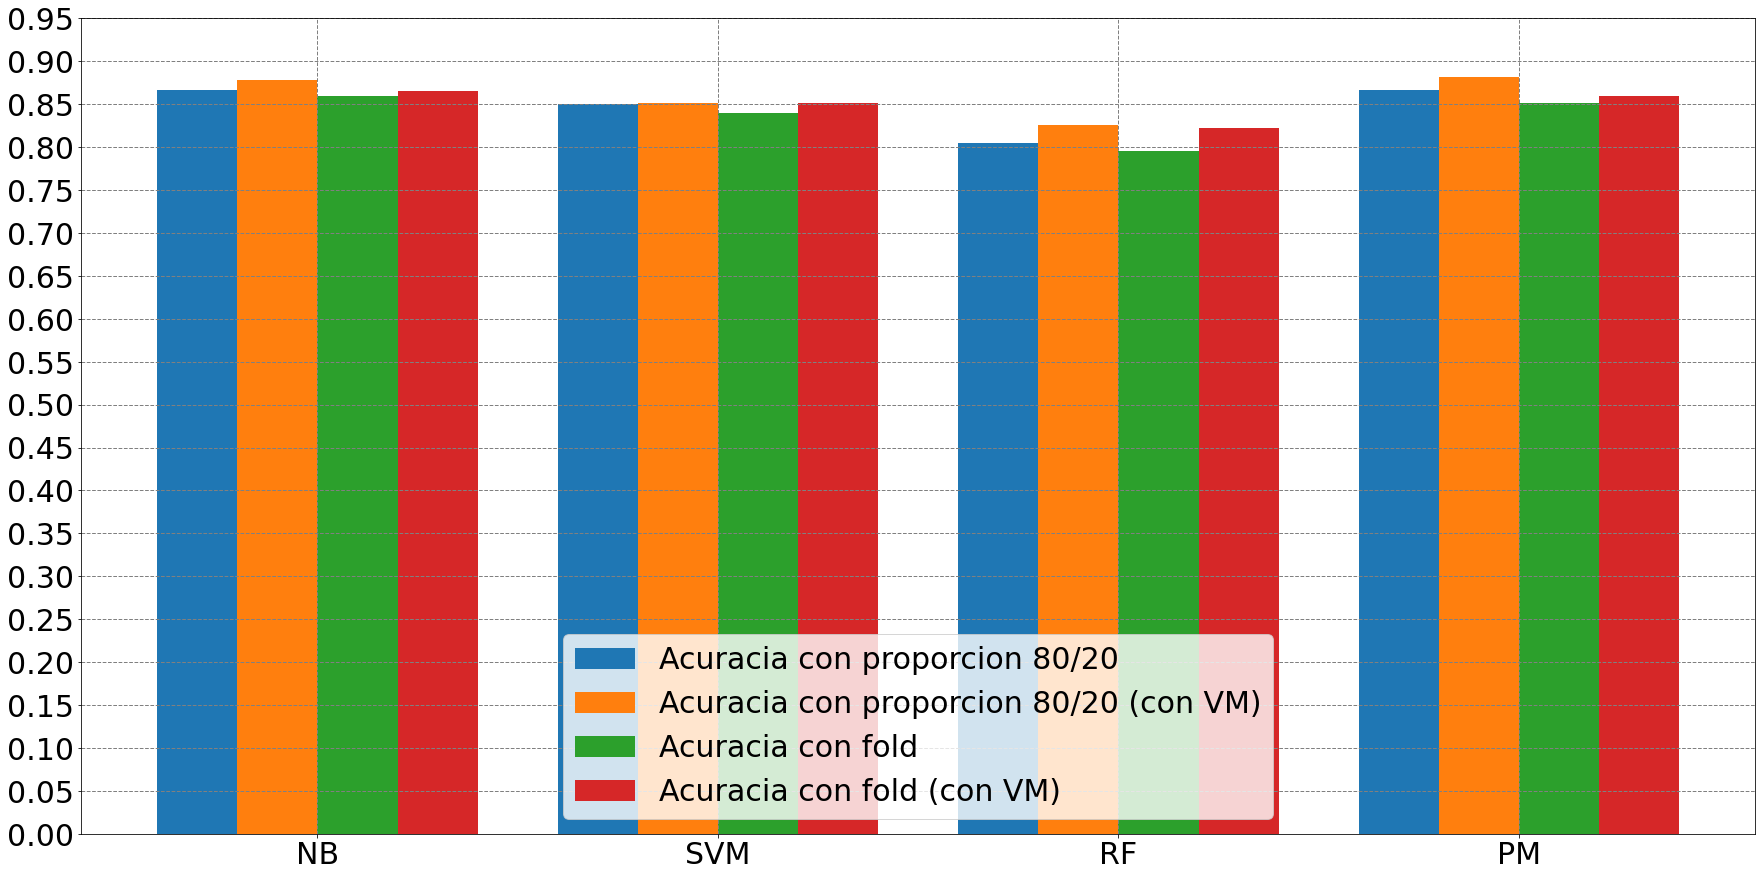

In [340]:
import numpy as np
n = len(data.index)
x = np.arange(n)
width = 0.2
plt.figure(figsize=(30, 15))
plt.bar(x - width, data.Acuracia_2080, width=width, label='Acuracia con proporcion 80/20')
plt.bar(x, data.Acuracia_VM_2080, width=width, label='Acuracia con proporcion 80/20 (con VM)')
#addlabels(x, data.Acuracia_VM_fold)
plt.bar(x + width, data.Acuracia_fold, width=width, label='Acuracia con fold')
plt.bar(x + 2*width, data.Acuracia_VM_fold, width=width, label='Acuracia con fold (con VM)')
#addlabels(x + 2*width, data.Acuracia_VM_2080)
#plt.bar(x + width, data.Recall, width=width, label='Recall')
plt.grid(color = 'grey', linestyle = '--', linewidth = 1)
plt.xticks(x + 0.1 , data.index,fontsize=30)
#np.arange(0.02,1.02,0.02)
plt.yticks(np.arange(0,1,0.05),fontsize=30)
plt.legend(loc='lower center', fontsize=30)
plt.savefig('acuracia_total.pdf', dpi=500)
plt.show()

## Naive Bayes

In [183]:
nb_classifier = nltk.classify.NaiveBayesClassifier
nb_class = nb_classifier.train(v_train)
#print(v_validation)
print ("Accuracy of the model = ", nltk.classify.accuracy(nb_class, v_validation))
#test_predict = [nb_class.classify(t) for (t,s) in v_test]

Accuracy of the model =  0.8662162162162163


Accuracy looks good enough, we can try now to train on the whole set and run on the Colombian tweets

In [184]:
#nb_class = nb_classifier.train(v_train_full) 
test_predict = [nb_class.classify(t) for (t,s) in v_test]
print ("Accuracy of the model = ", nltk.classify.accuracy(nb_class, v_test))
#print((test_predict),(y_test.to_list()))
print(len(y_test), len(test_predict))
accuracy_score(y_test, test_predict)

Accuracy of the model =  0.8783783783783784
1480 1480


0.8783783783783784

<function confusion_matrix at 0x000001D34674A0D0>
742 116 64 558


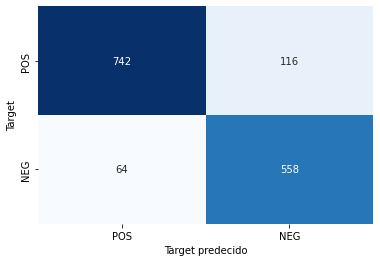

In [185]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# crear matriz de confusión
def confusion_matrix_graf(class_names, y_test, test_predict, name):
    #class_names= ['POS', 'NEG']
    matrix = confusion_matrix(y_test, test_predict)
    TN = matrix[0][0]
    FP = matrix[0][1]
    FN = matrix[1][0]
    TP = matrix[1][1]
    print(confusion_matrix)
    print(TN, FP, FN, TP)
    # crear marco de datos de pandas Crear un conjunto de datos
    dataframe = pd.DataFrame(matrix, index=class_names, columns=class_names)
    #print((dataframe))
    # crear mapa de calor dibujar mapa de calor
    sns.heatmap(dataframe, annot=True, cbar=None, cmap="Blues", fmt="d")
    #plt.title("Confusion Matrix"), plt.tight_layout()
    plt.ylabel("Target"), plt.xlabel("Target predecido")
    plt.savefig(name + '.pdf')
    plt.show()
    return TN, FP, FN, TP

TN, FP, FN, TP = confusion_matrix_graf(['POS', 'NEG'], y_test, test_predict,'PolVM_NB3_sin_mx')


In [186]:
#METRICAS
def calculo_metricas(TN, FP, FN, TP,test_predict):
    accuracia = (TP + TN) / len(test_predict)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    sensitive = TN /(TN + FP)
    F1_score = 2*(precision * sensitive) /(precision+sensitive)
    print(accuracia, precision, recall, sensitive, F1_score)

calculo_metricas(TN, FP, FN, TP, test_predict)

0.8783783783783784 0.827893175074184 0.8971061093247589 0.8648018648018648 0.8459451286787242


## SVM

In [187]:
from sklearn.svm import LinearSVC
svm_classifier = nltk.classify.SklearnClassifier(LinearSVC())
svm_class = svm_classifier.train(v_train)
#print(v_validation)
print ("Accuracy of the model = ", nltk.classify.accuracy(svm_class, v_validation))

Accuracy of the model =  0.8527027027027027


In [188]:
#nb_class = nb_classifier.train(v_train_full) 
test_predict = [svm_class.classify(t) for (t,s) in v_test]
print ("Accuracy of the model = ", nltk.classify.accuracy(svm_class, v_test))

Accuracy of the model =  0.8527027027027027


In [189]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_predict)

0.8527027027027027

<function confusion_matrix at 0x000001D34674A0D0>
770 88 130 492


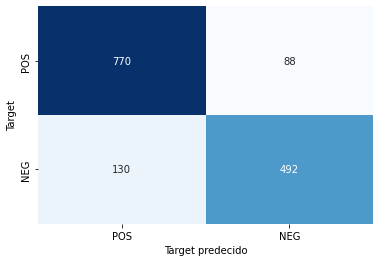

In [190]:
TN, FP, FN, TP = confusion_matrix_graf(['POS', 'NEG'], y_test, test_predict,'Pand_SVM_sin_mx')

In [191]:
calculo_metricas(TN, FP, FN, TP, test_predict)

0.8527027027027027 0.8482758620689655 0.7909967845659164 0.8974358974358975 0.872163695299838


## Random Forest

In [192]:
from sklearn.ensemble import RandomForestClassifier
dt_classifier = nltk.classify.SklearnClassifier(RandomForestClassifier())
dt_class = dt_classifier.train(v_train)
#print(v_validation)
print ("Accuracy of the model = ", nltk.classify.accuracy(dt_class, v_validation))

Accuracy of the model =  0.8243243243243243


In [193]:
#nb_class = nb_classifier.train(v_train_full) 
test_predict = [dt_class.classify(t) for (t,s) in v_test]
print("Accuracy of the model = ", nltk.classify.accuracy(dt_class, v_test))

Accuracy of the model =  0.8263513513513514


In [194]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_predict)

0.8263513513513514

<function confusion_matrix at 0x000001D34674A0D0>
802 56 201 421


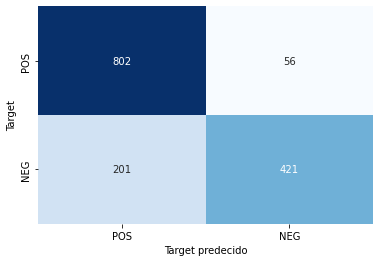

In [195]:
TN, FP, FN, TP = confusion_matrix_graf(['POS', 'NEG'], y_test, test_predict,'Pand_RF_sin_mx')

In [196]:
calculo_metricas(TN, FP, FN, TP, test_predict)

0.8263513513513514 0.8825995807127882 0.6768488745980707 0.9347319347319347 0.907918017887202


## Perceptron Multicapa

In [197]:
from sklearn.neural_network import MLPClassifier
perceptron_classifier = nltk.classify.SklearnClassifier(MLPClassifier(activation='relu', solver='adam', alpha=1e-5,
                    hidden_layer_sizes=(50,50), random_state=1,
                    learning_rate_init=0.001,max_iter=500,early_stopping=True))
dt_class = perceptron_classifier.train(v_train)
#print(v_validation)
print ("Accuracy of the model = ", nltk.classify.accuracy(dt_class, v_validation))

Accuracy of the model =  0.8702702702702703


In [198]:
#nb_class = nb_classifier.train(v_train_full) 
test_predict = [dt_class.classify(t) for (t,s) in v_test]
print ("Accuracy of the model = ", nltk.classify.accuracy(dt_class, v_test))

Accuracy of the model =  0.8817567567567568


In [199]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, test_predict)

0.8817567567567568

<function confusion_matrix at 0x000001D34674A0D0>
772 86 89 533


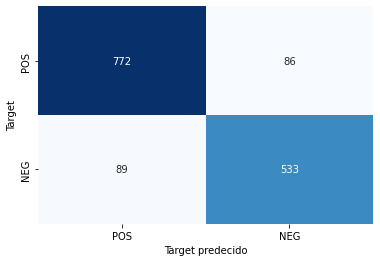

In [200]:
TN, FP, FN, TP = confusion_matrix_graf(['POS', 'NEG'], y_test, test_predict,'Pand_PM_sin_mx')

In [201]:
calculo_metricas(TN, FP, FN, TP, test_predict)

0.8817567567567568 0.8610662358642972 0.8569131832797428 0.8997668997668997 0.8799912744257268
